## Process OD data for KY

In [1]:
%matplotlib inline

import pandas as pd
import os
import contextlib
import geopandas as gp
import fiona
import shapely.geometry as geom

In [2]:
print(os.getcwd())
fileDir = 'blocks-output' 
os.chdir(fileDir)
input = 'od_original.csv'
output = 'od_2.csv'

/Users/mark/Documents/github-private/698-inspiration


In [3]:
def output_csv_data(out_file):
    with open(out_file, 'a') as f:
        df.to_csv(f, mode='a', index = None, header=f.tell()==0)

In [4]:
%time df = pd.read_csv(input, dtype={'w_geocode': str,'h_geocode':str,'createdate':str,'Hstatecounty_id': str,'Wstatecounty_id': str})

CPU times: user 2min 40s, sys: 1min 21s, total: 4min 1s
Wall time: 4min 26s


In [5]:
len(df)

109628603

#### Create a dataframe of KY worker locations

In [6]:
df = df[df['w_geocode'].str.startswith('21')]
len(df)

1323724

#### Create the Tract Geocode, Groupby

In [7]:
df['tract_w_geoid'] = df.w_geocode.str[:11]

In [8]:
df_group = df.groupby(['tract_w_geoid']).sum()
df_group.head()

,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03
tract_w_geoid,,,,,,,,,,
21001970100,11,1,7,3,6,3,2,4,7,0
21001970200,77,21,47,9,18,50,9,17,0,60
21001970300,91,23,55,13,25,45,21,35,20,36
21001970401,2250,544,1177,529,583,1126,541,299,496,1455
21001970402,1547,340,856,351,408,757,382,117,191,1239


In [77]:
df_group = df_group[(df_group['S000'] > 5000)]

In [78]:
top_tracts_list = df_group.index.tolist()

In [79]:
df2 = df[df['tract_w_geoid'].isin(top_tracts_list)]

In [ ]:
df2['tract_h_geoid'] = df2.h_geocode.str[:11]

In [81]:
len(df2)

387601

#### Remove `createdate` column

In [82]:
df2 = df2.drop(['createdate'], axis=1)

In [83]:
df2.head(10)

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,tract_w_geoid,tract_h_geoid
42015082,210099504001000,210099506003008,1,0,0,1,1,0,0,0,0,1,21009950400,21009950600
42015083,210099504001006,210099501003005,1,0,0,1,0,0,1,0,0,1,21009950400,21009950100
42015084,210099504001006,210099506005010,1,0,0,1,0,1,0,0,0,1,21009950400,21009950600
42015085,210099504001006,210099508001006,1,0,1,0,0,1,0,0,0,1,21009950400,21009950800
42015086,210099504001006,210879304001014,1,0,1,0,0,1,0,0,0,1,21009950400,21087930400
42015087,210099504001006,211010204002016,1,0,1,0,0,0,1,0,0,1,21009950400,21101020400
42015088,210099504001006,212270116004026,1,0,1,0,0,1,0,0,0,1,21009950400,21227011600
42015089,210099504001006,212270116004027,1,0,1,0,0,1,0,0,0,1,21009950400,21227011600
42015090,210099504001008,210099507002031,1,0,1,0,0,0,1,0,0,1,21009950400,21009950700
42015091,210099504001008,210099507003025,1,0,1,0,0,1,0,0,0,1,21009950400,21009950700


#### Create a tract geoid column for workplace and residence

In [84]:
df2['tract_w_geoid'] = df2.w_geocode.str[:11]
df2['tract_h_geoid'] = df2.h_geocode.str[:11]

In [85]:
df2.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,tract_w_geoid,tract_h_geoid
42015082,210099504001000,210099506003008,1,0,0,1,1,0,0,0,0,1,21009950400,21009950600
42015083,210099504001006,210099501003005,1,0,0,1,0,0,1,0,0,1,21009950400,21009950100
42015084,210099504001006,210099506005010,1,0,0,1,0,1,0,0,0,1,21009950400,21009950600
42015085,210099504001006,210099508001006,1,0,1,0,0,1,0,0,0,1,21009950400,21009950800
42015086,210099504001006,210879304001014,1,0,1,0,0,1,0,0,0,1,21009950400,21087930400


In [86]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387601 entries, 42015082 to 43295239
Data columns (total 14 columns):
w_geocode        387601 non-null object
h_geocode        387601 non-null object
S000             387601 non-null int64
SA01             387601 non-null int64
SA02             387601 non-null int64
SA03             387601 non-null int64
SE01             387601 non-null int64
SE02             387601 non-null int64
SE03             387601 non-null int64
SI01             387601 non-null int64
SI02             387601 non-null int64
SI03             387601 non-null int64
tract_w_geoid    387601 non-null object
tract_h_geoid    387601 non-null object
dtypes: int64(10), object(4)
memory usage: 44.4+ MB


#### Load the centroid file

In [87]:
%time centroids = pd.read_csv('tracts.csv', dtype={'STATEFP': 'object', 'COUNTYFP': 'object', 'TRACTCE': 'object', 'GEOID': 'object', 'INTPTLAT': 'float', 'INTPTLON': 'float'})
centroids.head()

CPU times: user 110 ms, sys: 26.4 ms, total: 137 ms
Wall time: 144 ms


,STATEFP,COUNTYFP,TRACTCE,GEOID,INTPTLAT,INTPTLON
0,01,087,232100,01087232100,32.403765,-85.717259
1,01,101,002201,01101002201,32.335613,-86.307803
2,01,101,002202,01101002202,32.315116,-86.303098
3,01,101,002300,01101002300,32.334080,-86.321932
4,01,101,002400,01101002400,32.341301,-86.335116


#### Merge the centroid data frame on the Fayette county w_geocode column

In [88]:
%time merge_result = pd.merge(df2, centroids,left_on=  ['tract_w_geoid'],right_on= ['GEOID'],how = 'left')
merge_result.drop(['GEOID'], axis=1, inplace=True)
merge_result.rename(columns={'STATEFP': 'w_statefp', 'COUNTYFP': 'w_countyfp', 'TRACTCE': 'w_tractce', 'INTPTLAT': 'w_lat', 'INTPTLON': 'w_lon'}, inplace=True)
merge_result.head()

CPU times: user 179 ms, sys: 35.2 ms, total: 214 ms
Wall time: 215 ms


,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,tract_w_geoid,tract_h_geoid,w_statefp,w_countyfp,w_tractce,w_lat,w_lon
0,210099504001000,210099506003008,1,0,0,1,1,0,0,0,0,1,21009950400,21009950600,21,009,950400,36.993863,-85.943694
1,210099504001006,210099501003005,1,0,0,1,0,0,1,0,0,1,21009950400,21009950100,21,009,950400,36.993863,-85.943694
2,210099504001006,210099506005010,1,0,0,1,0,1,0,0,0,1,21009950400,21009950600,21,009,950400,36.993863,-85.943694
3,210099504001006,210099508001006,1,0,1,0,0,1,0,0,0,1,21009950400,21009950800,21,009,950400,36.993863,-85.943694
4,210099504001006,210879304001014,1,0,1,0,0,1,0,0,0,1,21009950400,21087930400,21,009,950400,36.993863,-85.943694


In [89]:
merge_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387601 entries, 0 to 387600
Data columns (total 19 columns):
w_geocode        387601 non-null object
h_geocode        387601 non-null object
S000             387601 non-null int64
SA01             387601 non-null int64
SA02             387601 non-null int64
SA03             387601 non-null int64
SE01             387601 non-null int64
SE02             387601 non-null int64
SE03             387601 non-null int64
SI01             387601 non-null int64
SI02             387601 non-null int64
SI03             387601 non-null int64
tract_w_geoid    387601 non-null object
tract_h_geoid    387601 non-null object
w_statefp        387601 non-null object
w_countyfp       387601 non-null object
w_tractce        387601 non-null object
w_lat            387601 non-null float64
w_lon            387601 non-null float64
dtypes: float64(2), int64(10), object(7)
memory usage: 59.1+ MB


In [90]:
merge_result.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,tract_w_geoid,tract_h_geoid,w_statefp,w_countyfp,w_tractce,w_lat,w_lon
0,210099504001000,210099506003008,1,0,0,1,1,0,0,0,0,1,21009950400,21009950600,21,009,950400,36.993863,-85.943694
1,210099504001006,210099501003005,1,0,0,1,0,0,1,0,0,1,21009950400,21009950100,21,009,950400,36.993863,-85.943694
2,210099504001006,210099506005010,1,0,0,1,0,1,0,0,0,1,21009950400,21009950600,21,009,950400,36.993863,-85.943694
3,210099504001006,210099508001006,1,0,1,0,0,1,0,0,0,1,21009950400,21009950800,21,009,950400,36.993863,-85.943694
4,210099504001006,210879304001014,1,0,1,0,0,1,0,0,0,1,21009950400,21087930400,21,009,950400,36.993863,-85.943694


In [91]:
merge_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387601 entries, 0 to 387600
Data columns (total 19 columns):
w_geocode        387601 non-null object
h_geocode        387601 non-null object
S000             387601 non-null int64
SA01             387601 non-null int64
SA02             387601 non-null int64
SA03             387601 non-null int64
SE01             387601 non-null int64
SE02             387601 non-null int64
SE03             387601 non-null int64
SI01             387601 non-null int64
SI02             387601 non-null int64
SI03             387601 non-null int64
tract_w_geoid    387601 non-null object
tract_h_geoid    387601 non-null object
w_statefp        387601 non-null object
w_countyfp       387601 non-null object
w_tractce        387601 non-null object
w_lat            387601 non-null float64
w_lon            387601 non-null float64
dtypes: float64(2), int64(10), object(7)
memory usage: 59.1+ MB


#### Merge the centroid data frame on the Fayette county h_geocode column

In [92]:
%time merge_result = pd.merge(merge_result, centroids,left_on=  ['tract_h_geoid'],right_on= ['GEOID'],how = 'left')
merge_result.drop(['GEOID'], axis=1, inplace=True)
merge_result.rename(columns={'STATEFP': 'h_statefp', 'COUNTYFP': 'h_countyfp', 'TRACTCE': 'h_tractce', 'INTPTLAT': 'h_lat', 'INTPTLON': 'h_lon'}, inplace=True)
merge_result.head()

CPU times: user 223 ms, sys: 47.4 ms, total: 270 ms
Wall time: 275 ms


,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_statefp,w_countyfp,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon
0,210099504001000,210099506003008,1,0,0,1,1,0,0,0,...,21,009,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960
1,210099504001006,210099501003005,1,0,0,1,0,0,1,0,...,21,009,950400,36.993863,-85.943694,21,009,950100,37.092671,-85.849693
2,210099504001006,210099506005010,1,0,0,1,0,1,0,0,...,21,009,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960
3,210099504001006,210099508001006,1,0,1,0,0,1,0,0,...,21,009,950400,36.993863,-85.943694,21,009,950800,36.909434,-85.811902
4,210099504001006,210879304001014,1,0,1,0,0,1,0,0,...,21,009,950400,36.993863,-85.943694,21,087,930400,37.190657,-85.472415


In [93]:
# Create latitude longitude columns for the work location centroid (precision 4)
merge_result['h_lat'] = pd.to_numeric(merge_result['h_lat'])
merge_result['h_lon'] = pd.to_numeric(merge_result['h_lon'])
merge_result.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_statefp,w_countyfp,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon
0,210099504001000,210099506003008,1,0,0,1,1,0,0,0,...,21,009,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960
1,210099504001006,210099501003005,1,0,0,1,0,0,1,0,...,21,009,950400,36.993863,-85.943694,21,009,950100,37.092671,-85.849693
2,210099504001006,210099506005010,1,0,0,1,0,1,0,0,...,21,009,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960
3,210099504001006,210099508001006,1,0,1,0,0,1,0,0,...,21,009,950400,36.993863,-85.943694,21,009,950800,36.909434,-85.811902
4,210099504001006,210879304001014,1,0,1,0,0,1,0,0,...,21,009,950400,36.993863,-85.943694,21,087,930400,37.190657,-85.472415


In [95]:
# Pyproj docs - https://proj4.org/geodesic.html
# idea source: https://stackoverflow.com/questions/44446862/calculate-distance-between-latitude-and-longitude-in-dataframe

from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
  return dist

In [96]:
merge_result['distance'] = Distance(merge_result['w_lat'].tolist(),merge_result['w_lon'].tolist(),merge_result['h_lat'].tolist(),merge_result['h_lon'].tolist())

In [97]:
merge_result.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_countyfp,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon,distance
0,210099504001000,210099506003008,1,0,0,1,1,0,0,0,...,009,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960,11047.354937
1,210099504001006,210099501003005,1,0,0,1,0,0,1,0,...,009,950400,36.993863,-85.943694,21,009,950100,37.092671,-85.849693,13790.248275
2,210099504001006,210099506005010,1,0,0,1,0,1,0,0,...,009,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960,11047.354937
3,210099504001006,210099508001006,1,0,1,0,0,1,0,0,...,009,950400,36.993863,-85.943694,21,009,950800,36.909434,-85.811902,15019.393424
4,210099504001006,210879304001014,1,0,1,0,0,1,0,0,...,009,950400,36.993863,-85.943694,21,087,930400,37.190657,-85.472415,47248.995329


In [98]:
merge_result.sort_values('distance', ascending=False).head(5)

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_countyfp,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon,distance
38664,210190302001044,210759601001047,1,1,0,0,1,0,0,0,...,019,030200,38.487105,-82.649948,21,075,960100,36.547369,-88.997489,600866.278316
42063,210190302001181,210759601002010,1,0,1,0,1,0,0,0,...,019,030200,38.487105,-82.649948,21,075,960100,36.547369,-88.997489,600866.278316
38794,210190302001044,211059701005066,1,1,0,0,1,0,0,0,...,019,030200,38.487105,-82.649948,21,105,970100,36.675896,-88.972084,593349.868382
342649,211450314003015,211959317004023,1,0,1,0,0,1,0,0,...,145,031400,37.095235,-88.689675,21,195,931700,37.491987,-82.097953,586011.445495
342064,211450314003012,211959316002015,1,1,0,0,0,1,0,0,...,145,031400,37.095235,-88.689675,21,195,931600,37.562980,-82.192547,578036.030914


In [99]:
merge_result['distance meters'] = merge_result['distance'].apply(lambda x: round(x))

In [100]:
merge_result.head(10)

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon,distance,distance meters
0,210099504001000,210099506003008,1,0,0,1,1,0,0,0,...,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960,11047.354937,11047
1,210099504001006,210099501003005,1,0,0,1,0,0,1,0,...,950400,36.993863,-85.943694,21,009,950100,37.092671,-85.849693,13790.248275,13790
2,210099504001006,210099506005010,1,0,0,1,0,1,0,0,...,950400,36.993863,-85.943694,21,009,950600,37.025397,-85.825960,11047.354937,11047
3,210099504001006,210099508001006,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,009,950800,36.909434,-85.811902,15019.393424,15019
4,210099504001006,210879304001014,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,087,930400,37.190657,-85.472415,47248.995329,47249
5,210099504001006,211010204002016,1,0,1,0,0,0,1,0,...,950400,36.993863,-85.943694,21,101,020400,37.834998,-87.593211,173311.263132,173311
6,210099504001006,212270116004026,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,227,011600,37.005351,-86.230596,25569.567973,25570
7,210099504001006,212270116004027,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,227,011600,37.005351,-86.230596,25569.567973,25570
8,210099504001008,210099507002031,1,0,1,0,0,0,1,0,...,950400,36.993863,-85.943694,21,009,950700,36.955195,-85.938059,4320.525270,4321
9,210099504001008,210099507003025,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,009,950700,36.955195,-85.938059,4320.525270,4321


In [111]:
#limit the dataframe to any point with an 1.5 hour drive
#source: https://www.timecalculator.net/speed-distance-time-calculator

merge_limited = fayette[(merge_result['distance meters'] < 30000) & (merge_result['distance'] > 15000)]
#merge_limited = merge_result[(merge_result['distance meters']  > 240000)]
merge_limited.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon,distance,distance meters
3,210099504001006,210099508001006,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,009,950800,36.909434,-85.811902,15019.393424,15019
6,210099504001006,212270116004026,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,227,011600,37.005351,-86.230596,25569.567973,25570
7,210099504001006,212270116004027,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,227,011600,37.005351,-86.230596,25569.567973,25570
10,210099504001008,210099509001025,1,0,1,0,0,0,1,0,...,950400,36.993863,-85.943694,21,009,950900,36.840221,-85.953556,17073.221673,17073
18,210099504001009,210039201002007,1,0,1,0,0,1,0,0,...,950400,36.993863,-85.943694,21,003,920100,36.851530,-86.168613,25517.259571,25517


In [112]:
len(merge_limited)

88682

In [ ]:

merge_limited['geometry'] = merge_limited.apply(lambda x: geom.LineString([(x['w_lon'], x['w_lat'] ), (x['h_lon'],x['h_lat'])]), axis = 1)


In [114]:
gdf = gp.GeoDataFrame(merge_limited, geometry='geometry')

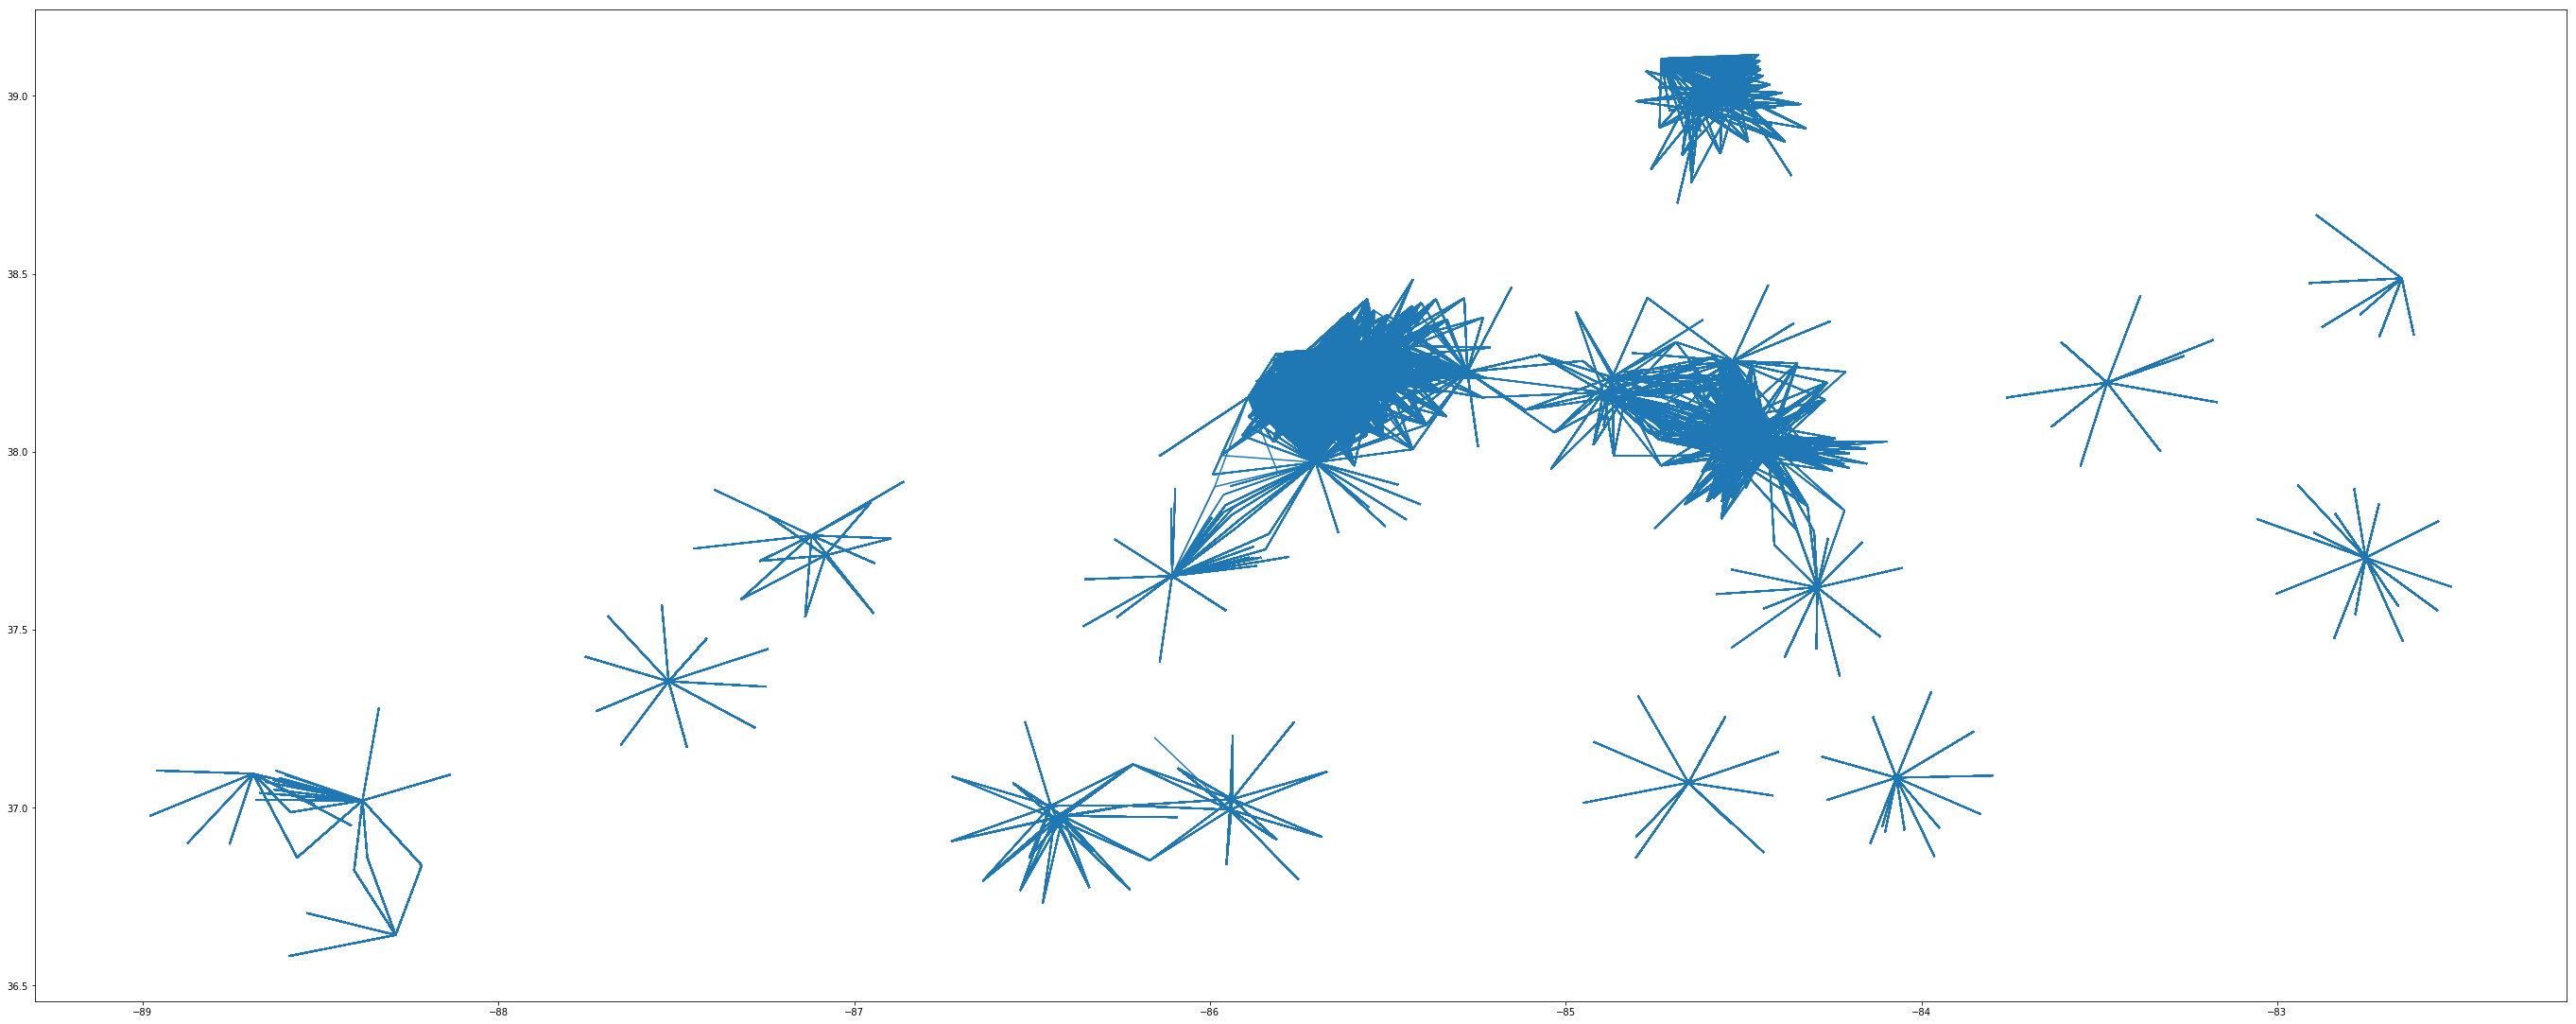

In [116]:
ax =gdf.plot(figsize=(48,48));

In [47]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 153566 entries, 53 to 1098505
Data columns (total 27 columns):
w_geocode          153566 non-null object
h_geocode          153566 non-null object
S000               153566 non-null int64
SA01               153566 non-null int64
SA02               153566 non-null int64
SA03               153566 non-null int64
SE01               153566 non-null int64
SE02               153566 non-null int64
SE03               153566 non-null int64
SI01               153566 non-null int64
SI02               153566 non-null int64
SI03               153566 non-null int64
tract_w_geoid      153566 non-null object
tract_h_geoid      153566 non-null object
w_statefp          153566 non-null object
w_countyfp         153566 non-null object
w_tractce          153566 non-null object
w_lat              153566 non-null float64
w_lon              153566 non-null float64
h_statefp          153566 non-null object
h_countyfp         153566 non-null object
h_tra

In [39]:
gdf.drop(['w_geocode', 'h_geocode', 'S000', 'SA01', 'SA02', 'SA03', 'SE01', 'SE02', 'SE03', 'SI01', 'SI02', 'SI03'], axis=1, inplace=True)

#### Write file to GeoJSON

In [41]:
gdf.to_file("output_x.json", driver="GeoJSON")